<a href="https://colab.research.google.com/github/Aduomas/PP11/blob/main/Practical_Project_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

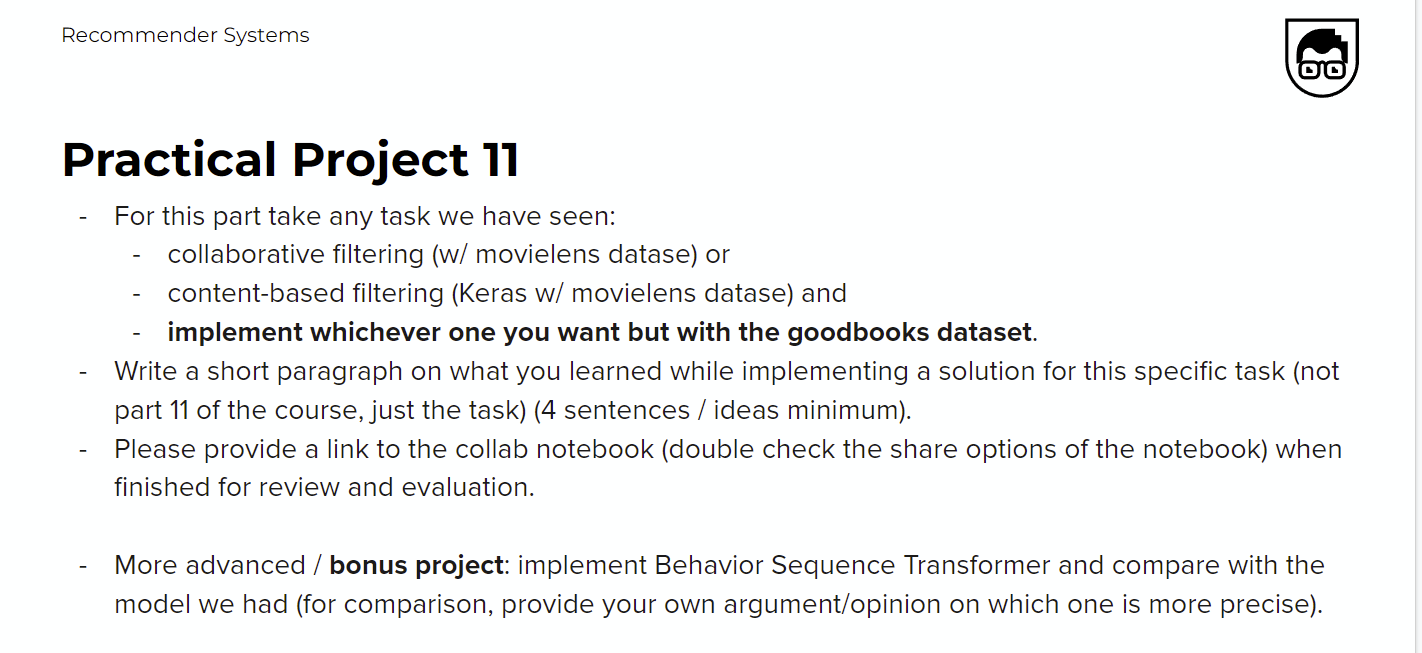

### Downloading goodboks dataset

In [ ]:
!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/book_tags.csv
!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv
!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv
!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/tags.csv
!wget https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/to_read.csv

In [ ]:
import pandas as pd

books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
book_tags = pd.read_csv('book_tags.csv')
tags = pd.read_csv('tags.csv')

In [ ]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [ ]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


### Data preprocess

In [ ]:
books['original_publication_year'] = books['original_publication_year'].fillna(-1).apply(lambda x: int(x) if x != -1 else -1)

In [ ]:
ratings_rmv_duplicates = ratings.drop_duplicates()
unwanted_users = ratings_rmv_duplicates.groupby('user_id')['user_id'].count()
unwanted_users = unwanted_users[unwanted_users < 3]
unwanted_ratings = ratings_rmv_duplicates[ratings_rmv_duplicates.user_id.isin(unwanted_users.index)]
new_ratings = ratings_rmv_duplicates.drop(unwanted_ratings.index)

In [ ]:
new_ratings['title'] = books.title.reindex(new_ratings.book_id).values
new_ratings

,user_id,book_id,rating,title
0,1,258,5,"The Scorch Trials (Maze Runner, #2)"
1,2,4081,4,"The Mistake (Off-Campus, #2)"
2,2,260,5,Under the Tuscan Sun
3,2,9296,5,One Flew Over the Cuckoo's Nest
4,2,2318,3,Don't Judge a Girl by Her Cover (Gallagher Gir...
...,...,...,...,...
5976474,49925,510,5,"Postmortem (Kay Scarpetta, #1)"
5976475,49925,528,4,Gulliver's Travels
5976476,49925,722,4,Shantaram
5976477,49925,949,5,I'll Give You the Sun


### Content based recommender

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

def get_genres(x):
    t = book_tags[book_tags.goodreads_book_id==x]
    return [i.lower().replace(" ", "") for i in tags.tag_name.loc[t.tag_id].values]

books['authors'] = books['authors'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x.split(', ')])
books['genres'] = books.book_id.apply(get_genres)
books['soup'] = books.apply(lambda x: ' '.join([x['title']] + x['authors'] + x['genres']), axis=1)

In [ ]:
books.soup.head()

0    The Hunger Games (The Hunger Games, #1) suzann...
1    Harry Potter and the Sorcerer's Stone (Harry P...
2    Twilight (Twilight, #1) stepheniemeyer to-read...
3                      To Kill a Mockingbird harperlee
4    The Great Gatsby f.scottfitzgerald favorites f...
Name: soup, dtype: object

### Count Vectorizer

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(books['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
indices = pd.Series(books.index, index=books['title'])
titles = books['title']

### Testing recommendations

In [ ]:
def get_recommendations(title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    book_indices = [i[0] for i in sim_scores]
    return list(titles.iloc[book_indices].values)[:n]

In [ ]:
get_recommendations("How to Win Friends and Influence People")

['Permission Marketing: Turning Strangers Into Friends And Friends Into Customers',
 'People of the Book',
 'Circle of Friends',
 'The Winter People',
 "Smiley's People",
 'The Bone People',
 'Summer People',
 'Ordinary People',
 'Better off Friends',
 'Friends and Lovers']

In [ ]:
searchfor = ['kaifu', 'tegmark', 'michu', 'kaku']
authors_books = books.apply(lambda x: x['authors'][0] if x['authors'] else None, axis=1)

books[authors_books.str.contains('|'.join(searchfor))]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,genres,soup
3788,3789,1168341,1168341,1239736,61,385520697,9.780386e+12,[michiokaku],2008,Physics of the Impossible: A Scientific Explor...,Physics of the Impossible: A Scientific Explor...,eng,4.07,22251,24597,1024,605,964,4342,8934,9752,https://images.gr-assets.com/books/1320469147m...,https://images.gr-assets.com/books/1320469147s...,[],Physics of the Impossible: A Scientific Explor...
6218,6219,33426,33426,629317,41,192861891,9.780193e+12,[michiokaku],1994,Hyperspace: A Scientific Odyssey Through Paral...,Hyperspace,eng,4.11,13941,15150,405,276,624,2622,5315,6313,https://images.gr-assets.com/books/1404794967m...,https://images.gr-assets.com/books/1404794967s...,[],Hyperspace michiokaku
6780,6781,33418,33418,33496,38,1400033721,9.781400e+12,[michiokaku],2004,"Parallel Worlds: A Journey Through Creation, H...","Parallel Worlds: A Journey Through Creation, H...",eng,4.17,12620,13385,441,159,427,2128,4998,5673,https://images.gr-assets.com/books/1435244003m...,https://images.gr-assets.com/books/1435244003s...,[],"Parallel Worlds: A Journey Through Creation, H..."
8552,8553,8492907,8492907,13358451,51,385530803,9.780386e+12,[michiokaku],2011,Physics of the Future: How Science Will Shape ...,Physics of the Future: How Science Will Shape ...,eng,3.98,10159,11605,919,212,532,2463,4461,3937,https://images.gr-assets.com/books/1320504811m...,https://images.gr-assets.com/books/1320504811s...,[],Physics of the Future: How Science Will Shape ...


In [ ]:
books.iloc[6218]['title']

'Hyperspace'

In [ ]:
get_recommendations("Hyperspace")

['Parallel Worlds: A Journey Through Creation, Higher Dimensions, and the Future of the Cosmos',
 'Physics of the Future: How Science Will Shape Human Destiny and Our Daily Lives by the Year 2100',
 'Physics of the Impossible: A Scientific Exploration into the World of Phasers, Force Fields, Teleportation, and Time Travel',
 'The Hunger Games (The Hunger Games, #1)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
 'Twilight (Twilight, #1)',
 'To Kill a Mockingbird',
 'The Great Gatsby',
 'The Fault in Our Stars',
 'The Hobbit']

In [ ]:
books.iloc[6780]['title']

'Parallel Worlds: A Journey Through Creation, Higher Dimensions, and the Future of the Cosmos'

In [ ]:
get_recommendations(books.iloc[6780]['title'])

['Cosmos',
 'Hyperspace',
 'The Once and Future King (The Once and Future King #1-4)',
 'The Hidden Reality: Parallel Universes and the Deep Laws of the Cosmos',
 'The Incredible Journey',
 'The Future of Us',
 "Grandfather's Journey",
 'Physics of the Future: How Science Will Shape Human Destiny and Our Daily Lives by the Year 2100',
 'Marie Antoinette: The Journey',
 'The Hundred-Foot Journey']

In [ ]:
def improved_recommendations(title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    book_indices = [i[0] for i in sim_scores]
    df = books.iloc[book_indices][['title', 'ratings_count', 'average_rating']]

    v = df['ratings_count']
    m = df['ratings_count'].quantile(0.85)
    R = df['average_rating']
    C = df['average_rating'].mean()
    df['weighted_rating'] = (R*v + C*m) / (v + m)
    
    qualified = df[df['ratings_count'] >= m]
    qualified = qualified.sort_values('weighted_rating', ascending=False)
    return qualified.head(n)

In [ ]:
improved_recommendations("How to Win Friends and Influence People")

,title,ratings_count,average_rating,weighted_rating
1704,Influence: The Psychology of Persuasion,45874,4.18,4.099528
662,A People's History of the United States,137372,4.07,4.053599
1749,How to Stop Worrying and Start Living,46797,4.08,4.040573
1010,People of the Book,95796,4.00,3.995483
2670,Circle of Friends,43936,4.00,3.992370
131,The Five People You Meet in Heaven,449501,3.90,3.905320
1941,Stories I Only Tell My Friends,47323,3.77,3.854300
3083,"The People of Sparks (Book of Ember, #2)",40859,3.65,3.793921
1878,Best Friends Forever,50738,3.48,3.671482


In [ ]:
improved_recommendations("Hyperspace")

,title,ratings_count,average_rating,weighted_rating
1,Harry Potter and the Sorcerer's Stone (Harry P...,4602479,4.44,4.343242
0,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,4.280513
3,To Kill a Mockingbird,3198671,4.25,4.214245
4,The Great Gatsby,2683664,3.89,4.026689
2,"Twilight (Twilight, #1)",3866839,3.57,3.809180


In [ ]:
get_recommendations(books.iloc[6780]['title'])

['Cosmos',
 'Hyperspace',
 'The Once and Future King (The Once and Future King #1-4)',
 'The Hidden Reality: Parallel Universes and the Deep Laws of the Cosmos',
 'The Incredible Journey',
 'The Future of Us',
 "Grandfather's Journey",
 'Physics of the Future: How Science Will Shape Human Destiny and Our Daily Lives by the Year 2100',
 'Marie Antoinette: The Journey',
 'The Hundred-Foot Journey']

### Pretty decent for some of the books.

### Conclusion

- I've chosen Content Based recommendation because I feel like it has more use cases for simple problems that I might encounter along the way and I would like to make a recommender.

- I've learnt that not much data preprocessing is required for this task to achieve decent results. Missing data such as nans for some columns doesn't impact too much.

- I've found that Goodbooks 10k dataset doesn't contain my recently read books such as 'AI Superpowers by Kaifu Lee', or 'Poor dad, Rich dad'. Which was unfortunate, because I would like to know what the model finds from dataset to be similar to these.

- I would like to explore Collaborative filtering recommender in the future and see what m